
# Applied ML Days - Workshop Part 2



## Preparations

This may take a couple of minutes..

In [3]:
!git clone https://github.com/i4Ds/AMLD-2022-Visual-Disinformation.git

Cloning into 'amld-workshop-part2'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [4]:
!tar -xf amld-workshop-part2/data/GRU_202012.tar.gz

In [5]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.4 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 6.5 MB 40.4 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Imports & Settings

In [32]:
import itertools
from pathlib import Path
from typing import List, Union, Optional

from IPython.core.display import display, HTML
import ipywidgets as widgets
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import torch
from transformers import CLIPModel, CLIPProcessor

## Load Data

In [7]:
root_path = Path('.')
campaign_id = 'GRU_202012'
data_path = root_path.joinpath(campaign_id)
df_tweets = pd.read_csv(data_path.joinpath("tweets.csv"), dtype=str)

In [8]:
clip_pre_computed_features_path = data_path.joinpath('clip_features')
clip_feature_files = [x for x in clip_pre_computed_features_path.glob("*.pt")]

In [9]:
with torch.no_grad():
    batch_data = [torch.load(f) for f in clip_feature_files]
    clip_features = torch.cat([b['image_features'] for b in batch_data])

In [10]:
clip_paths = list(
    itertools.chain.from_iterable([b['image_paths'] for b in batch_data]))
tweet_ids = list(
    itertools.chain.from_iterable([b['ids'] for b in batch_data]))

df_clip_paths = pd.DataFrame(
    {'path_image': clip_paths,
     'campaign_id': campaign_id,
     'tweetid': tweet_ids})

df_ml = (
    df_clip_paths
    .set_index('tweetid')
    .join(df_tweets.set_index('tweetid')[['tweet_text']], how='inner')
    .assign(
        path_image_abs=lambda df: [data_path.joinpath(x) for x in df.path_image]
        )
)

# sort dataframe correctly
df_ml = pd.merge(
    left=df_clip_paths,
    right=df_ml.reset_index(),
    on=['tweetid', 'path_image', 'campaign_id'],
    how='left')

assert df_ml.shape[0] == clip_features.shape[0], "feature / records missmatch"
assert list(df_ml.tweetid) == list(df_clip_paths.tweetid), "sort missmatch"

data = {'info': df_ml, 'clip_features': clip_features}


In [11]:
data['info'].head(3)

path_image campaign_id  \
0  media/images/GRU_202012_hashed_001/10136817644...  GRU_202012   
1  media/images/GRU_202012_hashed_001/10136822931...  GRU_202012   
2  media/images/GRU_202012_hashed_001/10137066494...  GRU_202012   

               tweetid                                         tweet_text  \
0  1013681764450127872  In the vicinity of Museeib, Tal Shihab, Abu Ka...   
1  1013682293158891520  Традиционные ценности украинского народа разру...   
2  1013706649440325633  «Shabab Al Sunna Forces», led by Mohammed Awad...   

                                      path_image_abs  
0  GRU_202012/media/images/GRU_202012_hashed_001/...  
1  GRU_202012/media/images/GRU_202012_hashed_001/...  
2  GRU_202012/media/images/GRU_202012_hashed_001/...

## Prepare CLIP Model

In [12]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


## Define Functions

### Visualisation

The following functions help us display the data.

In [78]:
#@title Visualisation Functions
def display_tweet(df: pd.DataFrame, idx: int) -> None:
    html = get_tweet_as_html(df, idx)
    display(HTML(html))


def get_tweet_as_html(df: pd.DataFrame, idx: int) -> str:
    row = df.iloc[idx]
    image = Image.open(row.path_image_abs)
    html = create_tweet_as_html(
        row.tweet_text, 
        image,
        {'tweetid': row.tweetid,
         'campaign_id': row.campaign_id})
    return html


def create_tweet_as_html(
      text:str ,
      image: Image.Image,
      meta_data:  Optional[dict]=None) -> str:
    """ Embedd text and image in html code """
    from io import BytesIO
    from base64 import b64encode
    b = BytesIO()  
    
    image.save(b, format='png')

    if meta_data:
        meta_str = ', '.join([f"{k}: {v}" for k, v in meta_data.items()])
        meta_str = f"({meta_str})"
    else:
        meta_str = ''
    html = (
    '<head>'
    '<meta charset="UTF-8">'
    '<style>'
      'img.tweet_image {'
        'border-radius: 15px;'
        'width: 600px;'
      '}'
      'div.tweet {'
        'max-width: 600px;'
       '}'
    '</style>'
    '</head>'
    '<body>'
        '<div class="tweet">'
        f"<b style='font-size:1.25em'>{text}</b>"
         "<figcaption> </figcaption>"
        f'<img class="tweet_image", src="data:image/png;base64,{b64encode(b.getvalue()).decode("utf-8")}">'
        f"<b style='font-size:0.8em'>{meta_str}</b>"
        '</div>'
    '</body>')
    return html


def get_nearest_observations_to_centroid(x, centroid):
    distance = np.sqrt(np.sum((x - np.array([centroid])) ** 2, axis=1))
    idx = np.argsort(distance)
    return idx
    

def display_cluster(df, x, centroid, max_to_display=50):
    idx = get_nearest_observations_to_centroid(x, centroid)
    
    idx = idx[0:max_to_display]
    idx_selector = widgets.Select(
        options=[x for x in idx],
        description='Indices',
        disabled=False,
    )
    # Display one example to notebook output
    _ = widgets.interact(
        display_tweet,
        idx=idx_selector,
        df=widgets.fixed(df))


### CLIP Functions

In [14]:
#@title CLIP specific functions
def create_clip_embeddigs_from_text(
      model,
      texts: Union[List[str], str]) -> torch.Tensor:
    """ Creates CLIP embeddings from a list of strings
        Args: 
            model: the CLIP model instance
            texts: a list of strings or a single string to convert to embeddings
        Returns:
            a tensor of shape (num_texts, 512) with the embeddings
    """
    text_embedding = processor(
        text=texts,
        padding='max_length',
        truncation=True,
        return_tensors="pt")
    with torch.no_grad():
        text_features = model.get_text_features(
            input_ids=text_embedding['input_ids'])
    return text_features


def clip_projection(
      x: torch.Tensor,
      y1: torch.Tensor,
      y2: torch.Tensor) -> torch.Tensor:
    """ Project observations x onto difference vector y1 - y2
        Args: 
            x: shape (N_INPUTS, N_FEATURES), observations to project
            y1 / y2: shape (1, N_FEATURES), start/end points
        Returns:
            tensor of shape (N_INPUTS, 1) with scores
    """
    x /= x.norm(dim=-1, keepdim=True)
    y1 /= y1.norm(dim=-1, keepdim=True)
    y2 /= y2.norm(dim=-1, keepdim=True)
    diff = y1 - y2
    return x.matmul(diff.T)


## Dataset Visualisation

Machine learning projects always start with data inspection. We are going to visually inspect some of the tweets to get an idea of what we can expect.

In [57]:
idx_selector = widgets.Select(
    options=np.linspace(0, data['info'].shape[0]-1, 40).astype(int),
    description='Indices',
    disabled=False
)

_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

interactive(children=(Select(description='Indices', options=(0, 212, 425, 638, 851, 1064, 1277, 1490, 1703, 19…

## Image Retrieval

The goal of this task is to find relevant images using the cross-modal embedding space of the CLIP model. We construct a text query and then compare its embedding to all the embeddings of the images in our dataset using dot products. We then select the k images with the largest values of the dot product.

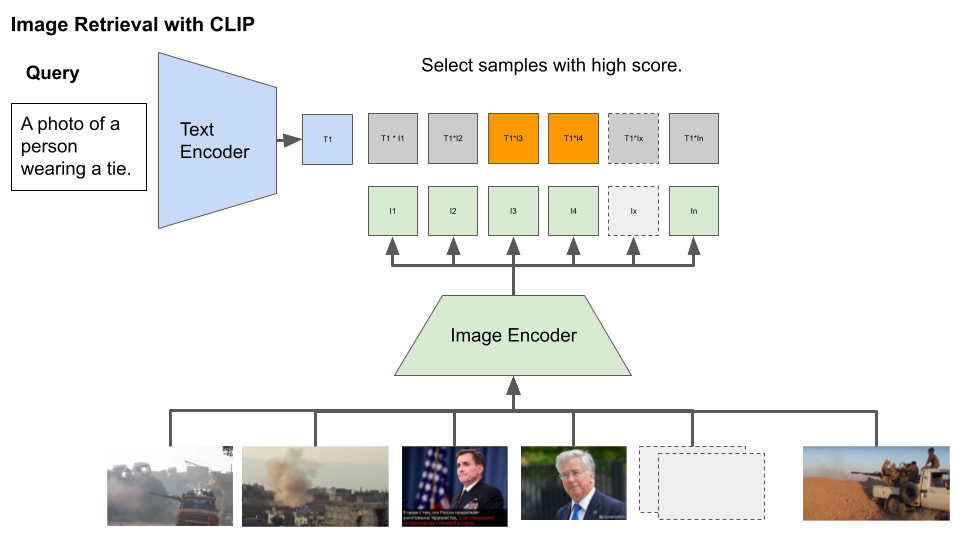

Complete the following function to calculate dot products between query and all images:

In [ ]:
def clip_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate similarities of each observation x to target y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (1, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, 1) with similarities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    
    # Complete code

In [ ]:
#@title Show Solution
def clip_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate similarities of each observation x to target y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (1, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, 1) with similarities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    return x.matmul(y.T)

Create a query to find photos of war planes.

In [44]:
query = "A photo of a war plane"

In [45]:
clip_query_embedding = create_clip_embeddigs_from_text(model, query)
similarity = clip_similarity(
    data['clip_features'],
    clip_query_embedding).numpy()
  
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

interactive(children=(Select(description='Indices', options=(7914, 7984, 8243, 537, 1351, 6172, 8181, 6741, 91…

Create other, possibly more complex queries. How good is the image retrieval?

In [ ]:
query = ""

clip_query_embedding = create_clip_embeddigs_from_text(model, query)
similarity = clip_similarity(
    data['clip_features'],
    clip_query_embedding).numpy()
  
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

## Zero-Shot Classification

In the following we will use CLIP for zero-shot learning. Meaning: We will define a set of classes of interest and callculate relative similarities for each image with respect to the different classes (sum over all classes is 1). This will assign each image to one of the classes (the one with the highest score).

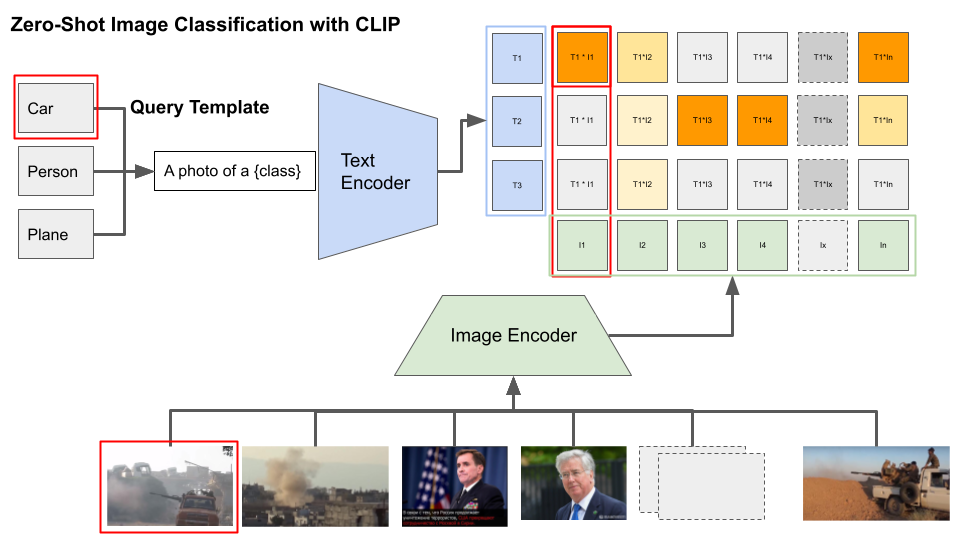

Create a zero-shot classifier to distingish between different types of media. Create fitting queries to identify: photographs, memes and documents. Use this order when creating the queries.

Finish the following function to calculate class probabilities:

In [ ]:
def clip_classifier(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate class probabilities of each observation x to all classes y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (N_CLASSES, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, N_CLASSES) with class probabilities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    # TODO: finish the following line of code, use the softmax transformation
    # to normalize the predictions between 0 and 1
    probs = .....
    return probs

In [ ]:
#@title Solution
def clip_classifier(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate class probabilities of each observation x to all classes y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (N_CLASSES, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, N_CLASSES) with class probabilities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    probs = (x @ y.T).softmax(dim=-1)
    return probs

Define the queries:

In [18]:
queries = [
    "",
    "",
    ""
]


In [ ]:
#@title Show a Solution
queries = [
    "This is a photograph",
    "This is a meme",
    "This is a document"
]

In [19]:
clip_query_embeddings = create_clip_embeddigs_from_text(model, queries)
similarity = clip_classifier(
    data['clip_features'],
    clip_query_embeddings).numpy()

Now we are displaying the examples most associate with the "photograph" class.

In [ ]:
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

Lets look at examples of "memes":

In [ ]:
sorted_indices = np.argsort(similarity[:, 1])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

And finally: let's take a look at the "document" class.

In [ ]:
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

## Emotion Analysis

Next, we are going to investigate if we can characterize images from these tweets along certain emotions that they might induce in a viewer of these images. This may be a goal of such frames.

The approach is very similar to zero-shot learning with the difference that we don't normalize the scores to produce class probabilities.

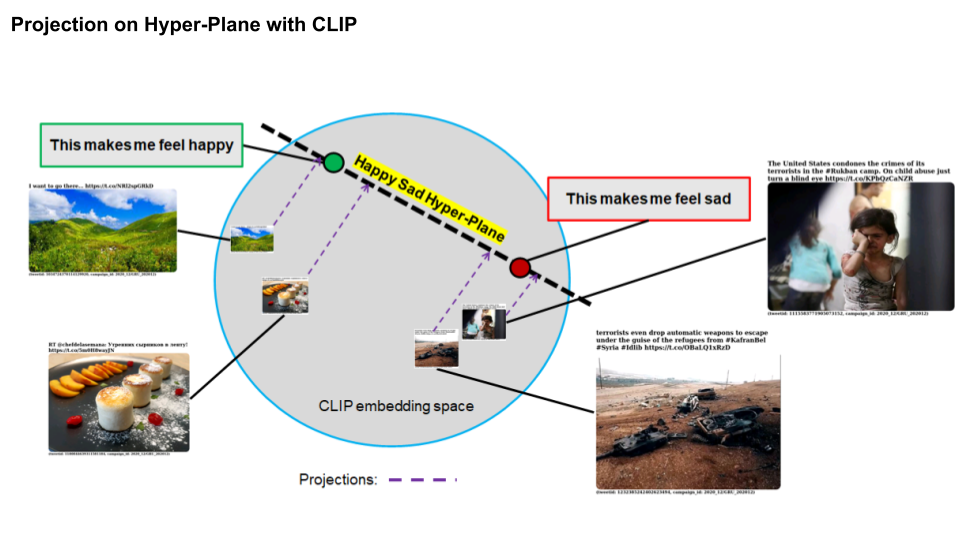

Create prompts using a list comprehension. Complete the following code:

In [47]:
emotions = ["happy", "sad"]
# Create a list of queries using a Python list comprehension
queries = ...


Click below for a solution.

In [ ]:
#@title Show a solution
emotions = ["happy", "sad"]
queries = [f"This makes me feel {x}" for x in emotions]

In [50]:
clip_text_embeddings = create_clip_embeddigs_from_text(model, queries)

emotion_score = clip_projection(
    x=data['clip_features'],
    y1=clip_text_embeddings[0:1, :],
    y2=clip_text_embeddings[1:, :]).numpy()

The following figure shows the distribution of the scores.

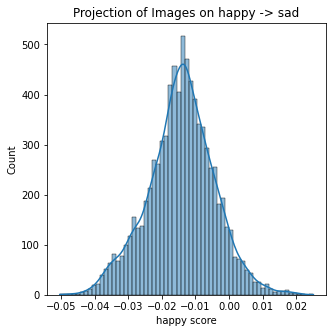

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = sns.histplot(emotion_score, ax=ax, kde='density', legend=False).set(
    title=f"Projection of Images on {emotions[0]} -> {emotions[1]}",
    xlabel=f"{emotions[0]} score")

### Display Happy Examples

In [52]:
sorted_indices = np.argsort(emotion_score[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)

In [53]:
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

interactive(children=(Select(description='Indices', options=(4178, 1385, 1524, 5457, 147, 6590, 3320, 2014, 38…

### Display Sad Examples

In [54]:
sorted_indices = np.argsort(emotion_score[:, 0])[:20]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)

In [55]:
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

interactive(children=(Select(description='Indices', options=(5050, 7019, 4670, 3429, 3729, 5060, 4394, 6189, 6…

Would you say that CLIP embeddings contain information about emotions?

### Optional Task: Inspect images with a neutral score.

In [ ]:
# TODO show neutral samples

In [ ]:
#@title Solution
sorted_indices = np.argsort(np.abs(emotion_score[:, 0]))[0:20]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

## Dimensionality Reduction

In the following, we are going to reduce the dimensionality of the CLIP embeddings (512-D) to 2-D in order to visualize the whole dataset as a point cloud. We might see some structure. We are going to use PCA and t-SNE for the dimensionality reduction. 

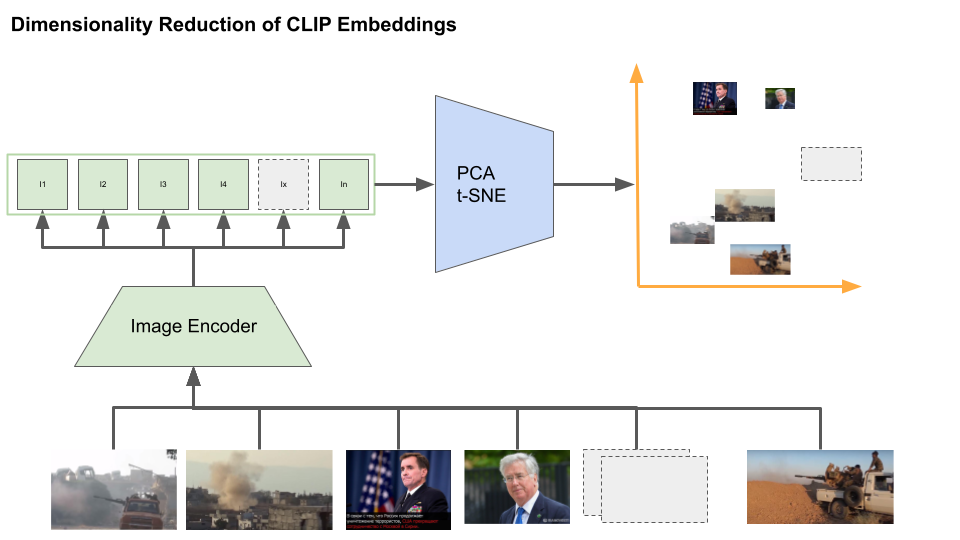

In [68]:
pca = PCA(n_components=50, random_state=123)
x_pca = pca.fit_transform(data['clip_features'].numpy())

In [69]:
tsne = TSNE(n_components=2, random_state=123, init='random', learning_rate='auto')
x_tsne = tsne.fit_transform(x_pca)

In [70]:
df_dim_red = pd.DataFrame(
    {'dim1': x_tsne[:, 0],
     'dim2': x_tsne[:, 1],
     'tweetid': data['info']['tweetid'],
     'tweet_text': data['info']['tweet_text']})

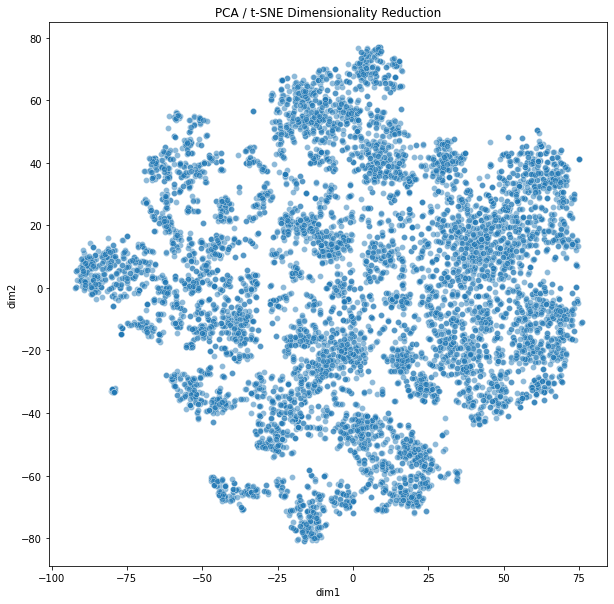

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.scatterplot(data=df_dim_red, x="dim1", y="dim2", ax=ax, alpha=0.5).set(
    title="PCA / t-SNE Dimensionality Reduction",
    xlabel="dim1", ylabel="dim2")

Visually inspect the data and identify clusters of points. Select a few of them, visualize examples, and try to characterize them. Select a cluster center and specify its coordinates in a list:

```
centroid = [dim1, dim2]
```



In [76]:
#@title Example Cluster
centroid = [-75, -30]

In [ ]:
display_cluster(df_ml, x_tsne, centroid)